

# **📊 Exploratory Data Analysis (EDA) — Structured by Subtasks**

---

# **1. Descriptive Statistics**

### **1.1 Headline Length Statistics**

**Goal:** Understand how long news headlines typically are.

**What to analyze:**

* Compute headline length in:

  * characters
  * words
* Generate summary statistics:

  * mean, median, min, max, standard deviation
* Plot histogram of headline lengths.

**Insights you can expect:**

* Short headlines often indicate breaking news.
* Longer headlines often include context (e.g., earnings reports or analyst commentary).

---

### **1.2 Article Count per Publisher**

**Goal:** Identify the most active information sources.

**What to compute:**

* Count number of articles per publisher.
* Sort in descending order.
* Visualize top publishers using a bar chart.

**Insights you can expect:**

* You may see heavy dominance from large outlets (e.g., Reuters, MarketWatch).
* A few publishers may account for most news, which affects sentiment bias.

---

### **1.3 Date-Based Trends**

**Goal:** Explore how publishing activity changes over time.

**What to analyze:**

* Number of articles published:

  * per day
  * per week
  * per month
* Identify:

  * spikes during earnings season
  * high-frequency days (e.g., Mondays)
  * periods of market turbulence (e.g., inflation reports, rate hikes)

**Insights you can expect:**

* News volume increases around major events (e.g., quarterly earnings).
* Fridays might show drops, while Monday spikes are common.

---

# **2. Text Analysis (Topic Modeling)**

### **2.1 Keyword Frequency**

**Goal:** Identify dominant themes in the news.

**Methods:**

* Tokenization & cleaning
* Remove stop words, numbers, special characters
* Generate:

  * word frequency table
  * word cloud (optional)
  * n-grams (bigrams, trigrams)

**Expected keywords:**

* “stock”, “price target”, “earnings”, “downgrade”, “merger”, “acquisition”.

---

### **2.2 Topic Modeling (LDA)**

**Goal:** Group headlines into meaningful **topics**.

**Outputs might look like:**

* **Topic 1: Earnings News**
  Keywords: earnings, quarterly, revenue, profit, forecast
* **Topic 2: Analyst Actions**
  Keywords: upgrade, downgrade, price target, rating
* **Topic 3: Market Movers**
  Keywords: surge, plunge, futures, rally
* **Topic 4: Legal/Regulatory**
  Keywords: lawsuit, regulation, FTC, approval, FDA

**Insight:**
Topic modeling helps link **sentiment** to **types of events**.

---

# **3. Time Series Analysis**

### **3.1 Publication Frequency Over Time**

**Goal:** Visualize how often news is published.

**Steps:**

* Convert date column to datetime.
* Resample:

  * Daily count
  * Weekly count
  * Monthly count
* Plot time series curve.

**Insights:**

* Sudden spikes highlight important macro events.
* Regular periodic patterns might show corporate cycles.

---

### **3.2 Publishing Time of Day**

**Goal:** Understand hourly behavior of news publishers.

**Steps:**

* Extract hour from timestamp (UTC-4).
* Count articles per hour.
* Plot distribution.

**Insights you may observe:**

* Majority of articles appear between **8:00–11:00 AM EST**, aligning with:

  * Pre-market trading
  * Market open (9:30 AM)
* Very few headlines appear late night (00:00–05:00).

**Usefulness:**

* Helps traders time automated alert systems.

---

### **3.3 Time Series Seasonality**

**Optional deeper-level analysis:**

* Decomposition into:

  * trend
  * seasonality
  * residual
* Helps understand if news volume is cyclical.

---

# **4. Publisher Analysis**

### **4.1 Most Active Publishers**

**Goal:** Determine which publishers dominate the dataset.

**Steps:**

* Rank publishers by article count.
* Visualize top 10 publishers.

**Possible findings:**

* Financial newswire services lead (e.g., Reuters, Bloomberg).
* Smaller blogs show low frequency but cross-sectional stock coverage.

---

### **4.2 Type of News Reported by Publishers**

**Goal:** Check if publishers specialize in different content.

**Approach:**

* For each publisher:

  * Perform keyword frequency analysis
  * Measure average sentiment score (later stage)
  * Identify typical topics they publish (earnings, ratings, political news)

**Example Expected Output:**

* Reuters → breaking news, market-moving events
* MarketWatch → analytical articles, commentary
* Yahoo Finance → general coverage, trending topics

---

### **4.3 Email-Domain-Based Analysis (If publishers contain emails)**

**Goal:** Identify contributing organizations.

**Steps:**

* Extract domain from publisher email (`split after @`)
* Count domain frequency

**Insights:**

* A single company might have multiple contributors.
* Some domains might indicate internal financial communities.

---




# Import and Setup

In [4]:

import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
import re
import matplotlib.pyplot as plt
# Make sure to download stopwords once
nltk.download('stopwords')




[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

#### Load Dataset

In [9]:
df = pd.read_csv("../data/raw_analyst_ratings.csv", index_col=0)
df.head()


,headline,url,publisher,date,stock
0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


In [10]:

# 1 chech the df info about there count and types
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1407328 entries, 0 to 1413848
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   headline   1407328 non-null  object
 1   url        1407328 non-null  object
 2   publisher  1407328 non-null  object
 3   date       1407328 non-null  object
 4   stock      1407328 non-null  object
dtypes: object(5)
memory usage: 64.4+ MB


#### Data Cleaning

In [21]:
# 2 Handling null Values
print("\n  Null value check (Before Cleaning)")
print(df.isnull().sum())
df.dropna(subset=['headline'],inplace=True)
print(f"after dropping null headlines:{df.shape[0]}")




  Null value check (Before Cleaning)
headline     0
url          0
publisher    0
date         0
stock        0
dtype: int64
after dropping null headlines:1407327


In [23]:

duplicate_count = df.duplicated().sum()
print(f"\n Total duplicate rows found: {duplicate_count}")
if duplicate_count > 0:
    df.drop_duplicates(inplace=True)
    print(f"\n rows remaining after dropping duplicates:{df.shape[0]}")

df["headline"] = df["headline"].astype(str)


 Total duplicate rows found: 0


In [24]:

# Converte date column to datetime
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'],format='mixed', utc=True) 
    print(f"Date type is now {df["date"].dtype}")

    #coverte the index to date
    df.set_index('date',inplace=True)

else:
    print("\nWarning: Date column not found. Skip date conversion")

Date type is now datetime64[ns, UTC]


##### Data Cleaning Summary

1. **Null Value Handling**
   - Checked for null values across all columns.
   - Dropped rows with null `headline` values, reducing the dataset by only 1 row (from 1,407,328 to 1,407,327).

2. **Duplicate Removal**
   - Checked for duplicate rows across all columns.
   - No duplicates were found, so no rows were removed.

3. **Data Type Standardization**
   - Converted the `headline` column to string type to ensure consistency for text processing.
   - Converted the `date` column to `datetime` type with UTC timezone awareness.
   - Set the `date` column as the DataFrame index for time-based analysis.

4. **Overall Dataset Preparedness**
   - After cleaning, the dataset was free of null headlines, duplicates, and had standardized data types, making it ready for **text analysis, time series analysis, and feature extraction**.


# Descriptive Statistics

#### Obtain basic statistics for textual lengths (like headline length).

In [46]:

df = df.assign(
    headline_length=df["headline"].astype(str).str.len(),
    headline_word_count=df["headline"].astype(str).str.split().str.len()
)
df[['headline_length','headline_word_count']].describe()

,headline_length,headline_word_count
count,1.407327e+06,1.407327e+06
mean,7.312054e+01,1.141671e+01
std,4.073532e+01,6.352998e+00
min,3.000000e+00,1.000000e+00
25%,4.700000e+01,7.000000e+00
50%,6.400000e+01,1.000000e+01
75%,8.700000e+01,1.300000e+01
max,5.120000e+02,7.700000e+01


##### Observations

- The majority of headlines are relatively short, around **10–13 words**.  
- Character lengths mostly fall between **47 and 87 characters**.  
- There are some extreme outliers with very short (**3 characters**) and very long (**512 characters**) headlines, which may require further cleaning or investigation for analysis robustness.  

##### Implications for Analysis

- Typical headlines are concise, which is common in financial news.  
- Word-level tokenization and NLP analysis should account for occasional unusually long headlines, which might disproportionately affect some models (e.g., TF-IDF weighting or LDA).


#### Count the number of articles per publisher to identify which publishers are most active.

In [28]:
# count peblisher 
publisher_counts = df['publisher'].value_counts()
publisher_counts

publisher
Paul Quintaro        228373
Lisa Levin           186978
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
                      ...  
MoneyGeek                 1
muathe                    1
Robert Morris             1
LeftCoastHedgie           1
Jeremie Capron            1
Name: count, Length: 1034, dtype: int64

##### Publisher Activity Analysis

- **Most Active Publishers:**
  - **Paul Quintaro:** 228,373 articles
  - **Lisa Levin:** 186,978 articles
  - **Benzinga Newsdesk:** 150,484 articles
  - **Charles Gross:** 96,732 articles
  - **Monica Gerson:** 82,380 articles

- **Least Active Publishers:**
  - Some publishers have published only **1 article** (e.g., MoneyGeek, muathe, Robert Morris, LeftCoastHedgie, Jeremie Capron).

##### Observations

- A small number of publishers account for a large proportion of the dataset.
- Many publishers contribute very few articles, creating a long-tail distribution.
- Analysis of trends or sentiment may be dominated by the most prolific publishers unless normalized.

##### Implications for Analysis

- Consider weighting or sampling methods to avoid bias from highly prolific publishers.
- Publisher-level trends or patterns could be skewed by the top contributors.


#### Analyze the publication dates to see trends over time, such as increased news frequency on particular days or during specific events.

In [29]:
df['day'] = df.index.day
# This shows daily publication frequency:
daily_counts = df.index.normalize().value_counts().sort_index()
print(daily_counts)

date
2009-02-14 00:00:00+00:00      1
2009-04-27 00:00:00+00:00      2
2009-04-29 00:00:00+00:00      1
2009-05-22 00:00:00+00:00      1
2009-05-27 00:00:00+00:00      6
                            ... 
2020-06-07 00:00:00+00:00     25
2020-06-08 00:00:00+00:00    765
2020-06-09 00:00:00+00:00    803
2020-06-10 00:00:00+00:00    807
2020-06-11 00:00:00+00:00    544
Name: count, Length: 3955, dtype: int64


<Axes: title={'center': 'Articles per Day'}, xlabel='date'>

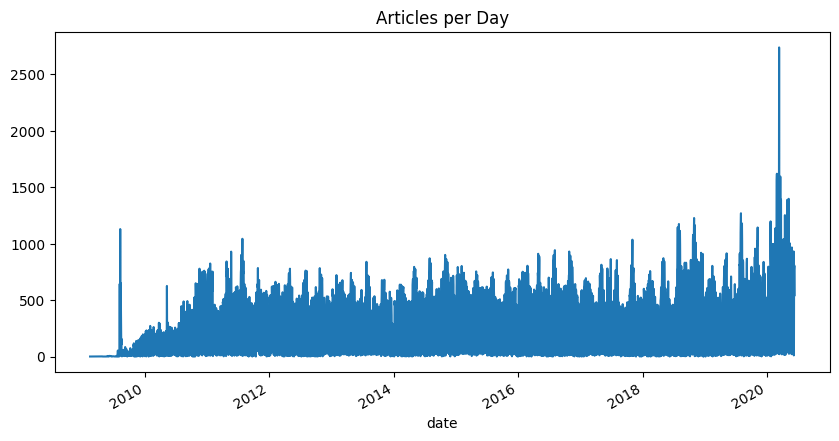

In [30]:
daily_counts.plot(kind='line', figsize=(10,5), title='Articles per Day')


##### Article Publication Trends

##### Observations
- The dataset spans from **2009 to mid-2020**, with **3,955 unique dates** recorded.  
- **Daily article counts** vary significantly, from as few as **1 article** on some days to over **2,500 articles** on peak days.  
- The overall trend shows a **gradual increase** in publishing activity over the years, with several **sharp spikes**, likely corresponding to major financial events or breaking news.  
- The most intense activity occurs in **2020**, with several consecutive days exceeding **1,000 articles**.  

##### Visualization
*(Insert chart or graph here)*

##### Implications for Analysis
- Peaks in daily publication may influence **sentiment analysis** or **topic modeling** if high-frequency days are overrepresented.  
- **Time-series analysis** or forecasting should account for **uneven publication frequency**, with potential adjustments for holidays, weekends, or major events.  
- **NLP models** trained on this dataset should be robust to **variations in daily news volume**.


# Text Analysis(Topic Modeling)

#### Use natural language processing to identify common keywords or phrases, potentially extracting

In [31]:
def preprocess(text):
    text = text.lower()  # lowercase
    text = re.sub(r'[^a-z\s]', '', text)  # remove punctuation/numbers
    return text

In [32]:
#Clean headline
df['clean_headline'] = df['headline'].apply(preprocess)

In [35]:
# CountVectorizer for unigrams and bigrams
vectorizer = CountVectorizer(stop_words=stopwords.words('english'), ngram_range=(1,2))
X = vectorizer.fit_transform(df['clean_headline'])

# Sum up word counts
word_counts = X.sum(axis=0)
words_freq = [(word, word_counts[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

print("Top keywords/phrases:")
for word, freq in words_freq[:10]:
    print(word, freq)

Top keywords/phrases:
vs 162147
stocks 161868
est 140606
vs est 129338
eps 128929
shares 114209
reports 108707
update 91680
market 90880
earnings 87185


##### Summary of Financial News Headlines Analysis

Analysis of the financial news headlines reveals that the dataset is primarily focused on **stock market performance and corporate earnings**. The most frequent terms include `vs`, `stocks`, `est`, `eps`, `shares`, `reports`, `update`, `market`, and `earnings`, with bigrams such as `vs est` highlighting comparisons between actual and estimated financial results. 

This indicates that the headlines largely center on **company performance metrics, earnings reports, and market updates**, reflecting the financial focus of the news content.


# Time Series Analysis

#### How does the publication frequency vary over time? Are there spikes in article publications related to specific market events?

In [39]:
# Normalize index to get dates only and count occurrences
daily_counts = df.index.normalize().value_counts().sort_index().reset_index()
daily_counts.columns = ['date', 'article_count']

daily_counts.head()

,date,article_count
0,2009-02-14 00:00:00+00:00,1
1,2009-04-27 00:00:00+00:00,2
2,2009-04-29 00:00:00+00:00,1
3,2009-05-22 00:00:00+00:00,1
4,2009-05-27 00:00:00+00:00,6


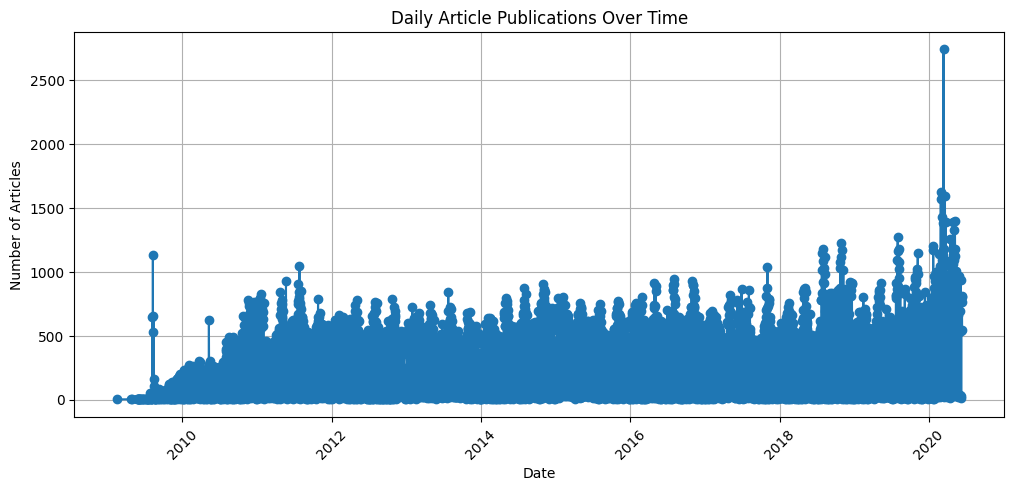

In [40]:
plt.figure(figsize=(12,5))
plt.plot(daily_counts['date'], daily_counts['article_count'], marker='o')
plt.title('Daily Article Publications Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

##### Insights

- Article publication is irregular at the start of the dataset (2009), with some days having only 1–2 articles.

- There are noticeable days with higher counts (e.g., 6 articles on 2009-05-27), suggesting spikes in coverage.

- These spikes likely correspond to **major financial or market events**, although further investigation (e.g., mapping dates to events like earnings releases, market crashes, or policy announcements) is needed to confirm.


In [41]:
df.index.to_series().head(20)

date
2020-06-05 14:30:54+00:00   2020-06-05 14:30:54+00:00
2020-06-03 14:45:20+00:00   2020-06-03 14:45:20+00:00
2020-05-26 08:30:07+00:00   2020-05-26 08:30:07+00:00
2020-05-22 16:45:06+00:00   2020-05-22 16:45:06+00:00
2020-05-22 15:38:59+00:00   2020-05-22 15:38:59+00:00
2020-05-22 15:23:25+00:00   2020-05-22 15:23:25+00:00
2020-05-22 13:36:20+00:00   2020-05-22 13:36:20+00:00
2020-05-22 13:07:04+00:00   2020-05-22 13:07:04+00:00
2020-05-22 12:37:59+00:00   2020-05-22 12:37:59+00:00
2020-05-22 12:06:17+00:00   2020-05-22 12:06:17+00:00
2020-05-22 00:00:00+00:00   2020-05-22 00:00:00+00:00
2020-05-22 00:00:00+00:00   2020-05-22 00:00:00+00:00
2020-05-21 00:00:00+00:00   2020-05-21 00:00:00+00:00
2020-05-21 00:00:00+00:00   2020-05-21 00:00:00+00:00
2020-05-21 00:00:00+00:00   2020-05-21 00:00:00+00:00
2020-05-21 00:00:00+00:00   2020-05-21 00:00:00+00:00
2020-05-18 00:00:00+00:00   2020-05-18 00:00:00+00:00
2020-05-16 00:00:00+00:00   2020-05-16 00:00:00+00:00
2020-05-15 00:00:00+00:

C:\Users\user\AppData\Local\Temp\ipykernel_19756\135907017.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_time['hour'] = real_time.index.hour


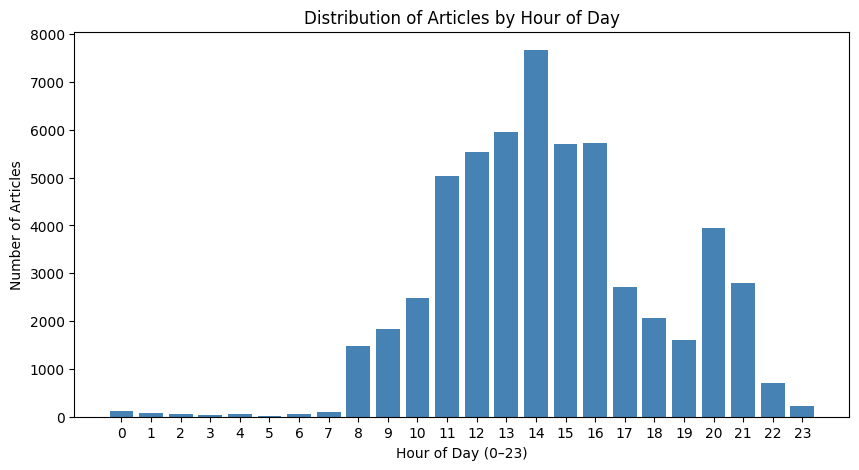

In [42]:
# Extract hour from timestamp index
real_time = df[df.index.time != pd.to_datetime("00:00:00").time()]
real_time['hour'] = real_time.index.hour

# Count articles per hour
hour_counts = real_time['hour'].value_counts().sort_index()

# Plot
plt.figure(figsize=(10, 5))
plt.bar(hour_counts.index, hour_counts.values, color='steelblue')
plt.xlabel('Hour of Day (0–23)')
plt.ylabel('Number of Articles')
plt.title('Distribution of Articles by Hour of Day')
plt.xticks(range(24))
plt.show()

### Insights

- Article publications are concentrated during **normal market hours**, typically from early morning to late afternoon.

- Very few articles are published late at night or very early morning, indicating most content is released during **business hours**, likely aligned with market activity and news cycles.


# Publisher Analysis

#### Which publishers contribute most to the news feed? Is there a difference in the type of news they report?

publisher
Paul Quintaro        228373
Lisa Levin           186978
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Eddie Staley          57254
Hal Lindon            49047
ETF Professor         28489
Juan Lopez            28438
Benzinga Staff        28114
Name: count, dtype: int64


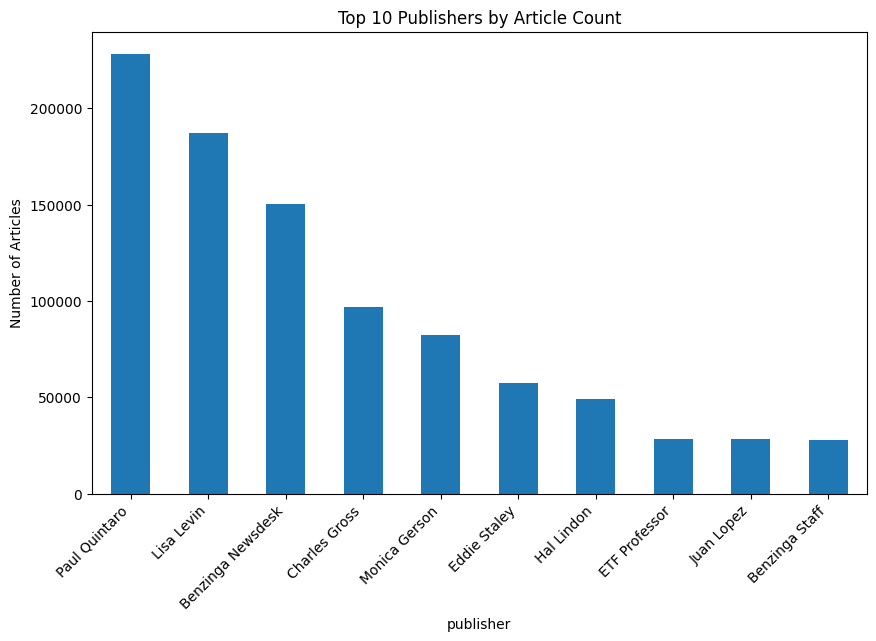

In [43]:

# Count the number of articles per publisher:
publisher_counts = df['publisher'].value_counts()

# Show the top 10:
top_publishers = publisher_counts.head(10)
print(top_publishers)


plt.figure(figsize=(10,6))
top_publishers.plot(kind='bar')
plt.ylabel('Number of Articles')
plt.title('Top 10 Publishers by Article Count')
plt.xticks(rotation=45, ha='right')
plt.show()



**Insights:**

- Paul Quintaro, Lisa Levin, and Benzinga Newsdesk are the top three publishers, contributing a significant portion of the dataset.  
- The distribution shows that a few publishers dominate article production, while many others contribute smaller volumes.  
- This suggests that **market news coverage is concentrated among a limited number of active contributors**, which may influence the overall content tone and focus.

#### If email addresses are used as publisher names, identify unique domains to see if certain organizations contribute more frequently

domain
benzinga.com              7937
gmail.com                  139
andyswan.com                 5
investdiva.com               2
tothetick.com                2
eosdetroit.io                1
forextraininggroup.com       1
stockmetrix.net              1
Name: count, dtype: int64


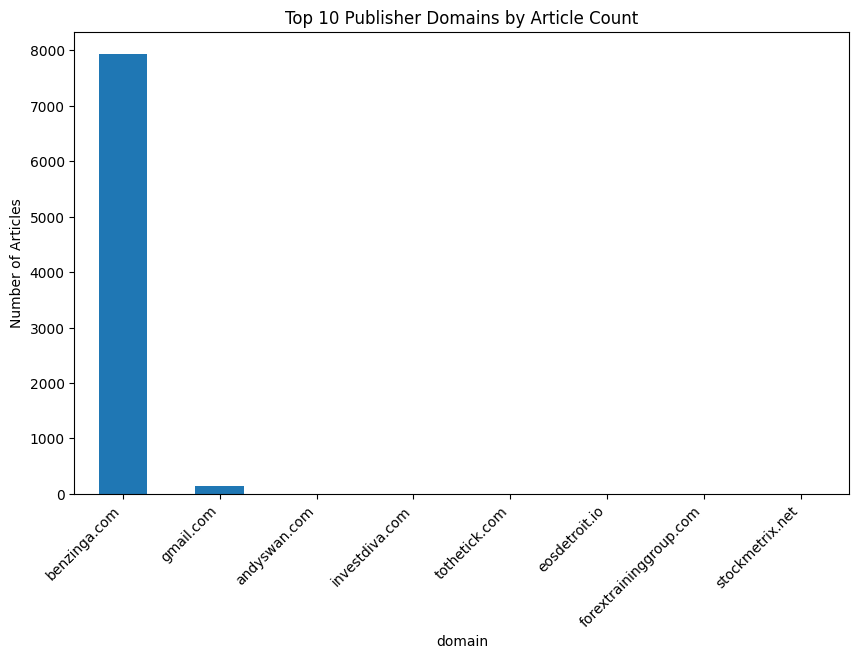

In [45]:
# Extract domain from email addresses
df['domain'] = df['publisher'].str.extract(r'@([\w\.-]+)')

# Count frequency of each domain
domain_counts = df['domain'].value_counts()

# Show top 10 domains
print(domain_counts.head(10))

# Plot top 10 domains
plt.figure(figsize=(10,6))
domain_counts.head(10).plot(kind='bar')
plt.ylabel('Number of Articles')
plt.title('Top 10 Publisher Domains by Article Count')
plt.xticks(rotation=45, ha='right')
plt.show()

##### Insights

- The majority of articles with email-based publisher names come from **benzinga.com**, indicating that this organization is the primary contributor.  
- Other domains such as **gmail.com** and small independent sites contribute very few articles, suggesting that most content is dominated by a single organization rather than dispersed across many independent contributors.
